## 7. Time Series Forecasting with LightGBM

**Overview:**

- A prediction model will be constructed using the LightGBM machine learning model and the feature set selected in the previous chapter. The aim is to build the most accurate model for this project through a process involving baseline forecasting, hyperparameter optimization with Optuna, and final evaluation.


# Solar Power Generation and Electricity Demand Forecasting with LightGBM

## 1. Objective
In this notebook, we will perform time series forecasting of solar power generation (`solar_gen_mw`) and electricity demand (`e_demand_mw`) using the machine learning model LightGBM.

Model building and evaluation will be conducted on the feature-engineered dataset using the following steps:
1.  Building and evaluating a baseline model
2.  Hyperparameter optimization using Optuna
3.  Final prediction and evaluation with the optimized model

This aims to verify the effectiveness of LightGBM in time series forecasting tasks and the improvement in accuracy achieved through hyperparameter tuning.


### 7-1. Preparation

- Train LightGBM as a predictive model and define a wrapper function to output predictions.
- Considering tuning with Optuna, design it to accept hyperparameters as arguments.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import List, Tuple, Callable, Dict, Optional, Any

import optuna

# Import common modules
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.forecast_utils import sliding_window_forecast_with_features
from src.plot_utils import plot_forecast_vs_actual

# Style and warning settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo'
warnings.filterwarnings('ignore')


#### 7-1-2. Data Loading and Common Settings

- Load the time series data to be predicted (feature-engineered). Also, define the list of features to be used for each prediction target and various parameters used in the sliding window method.
- Use `src/forecast_utils.py sliding_window_forecast_with_features` for the sliding window function with explanatory variable columns.


In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "df_shifted.csv"

df = load_timeseries_data(target_file)

print("Data shape:", df.shape)
print("Data period:", df.index.min(), "to", df.index.max())
df.head()

# Definition of target and explanatory variables
TARGETS = {
    'solar_shifted': [
        'solar_radiation', 'cos_hour', 'sunshine_duration', 'temperature',
        'sin_hour', 'pressure_local', 'precipitation', 'humidity', 'wind_speed',
        'sin_weekday'],
    'demand_shifted': [
        'vapor_pressure', 'temperature', 'humidity', 'sin_hour', 'cos_hour',
        'solar_radiation', 'sin_weekday', 'cos_weekday', 'is_holiday',
        'pressure_local', 'precipitation'
    ]
}

# Common parameters for sliding window
TRAIN_LENGTH = 2880  # 60 days * 48 points/day
TEST_LENGTH = 48     # 1 day * 48 points/day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day (non-overlapping)
OPTUNA_TRIALS = 40   # Number of Optuna trials


Data shape: (39360, 16)
Data period: 2023-01-01 00:00:00 to 2025-03-30 23:30:00


In [3]:
def lgb_forecast(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    **kwargs: Any  # model_params and fit_params are mixed and passed via kwargs
) -> Tuple[np.ndarray, lgb.LGBMRegressor, None]:
    
    # A wrapper function to train a LightGBM model and make predictions.
    # Separate model_params and fit_params from kwargs.
    
    # 1. Define keys belonging to fit_params
    # These are passed to model.fit() and not to the LGBMRegressor() constructor
    FIT_PARAM_KEYS = ['eval_set_provider', 'callbacks']
    
    model_params = {}
    fit_params_internal = {}
    
    # Distribute kwargs
    for key, value in kwargs.items():
        if key in FIT_PARAM_KEYS:
            fit_params_internal[key] = value
        else:
            model_params[key] = value # Otherwise, consider them as model hyperparameters

    # 2. Type conversion for int parameters (performed on model_params)
    int_params = ['num_leaves', 'max_depth', 'min_child_samples', 'n_estimators']
    for param in int_params:
        if param in model_params:
            try:
                # To avoid errors when trying to convert None or strings like "auto" to int
                if model_params[param] is not None:
                    model_params[param] = int(model_params[param])
            except (ValueError, TypeError):
                pass # Values that cannot be converted are left as is

    # 3. Model initialization
    # model_params includes 'n_estimators', 'learning_rate', etc.
    model = lgb.LGBMRegressor(random_state=42, **model_params)
    
    # 4. Model training (with Early Stopping support)
    # If 'eval_set_provider' is in fit_params_internal, use it
    if "eval_set_provider" in fit_params_internal:
        eval_set, X_tr, y_tr = fit_params_internal["eval_set_provider"](X_train, y_train)
        
        current_fit_params = {
            "eval_set": eval_set,
            "callbacks": fit_params_internal.get("callbacks", [])
        }
        model.fit(X_tr, y_tr, **current_fit_params)
    else:
        # If 'eval_set_provider' is not present (e.g., for baseline prediction)
        model.fit(X_train, y_train)

    # 5. Prediction
    preds = model.predict(X_test)
    return preds, model, None


### 7-2. Prediction of Solar Power Generation (solar_gen_mw: solar_shifted)


In [4]:
# Set the target variable for prediction
target_col_solar = 'solar_shifted'
feature_cols_solar = TARGETS[target_col_solar]
print(f" Starting Forecast for: {target_col_solar}")


 Starting Forecast for: solar_shifted


#### 7-2-1. Baseline Prediction
- First, we will build a baseline prediction model using LightGBM's default parameters and evaluate its accuracy. This will establish a benchmark to measure the effectiveness of hyperparameter optimization.


[Phase 1/3] Running initial forecast with default parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

Initial Forecast Metrics:
MAE     1358.231313
RMSE    2728.585423
MASE       1.846009
dtype: float64


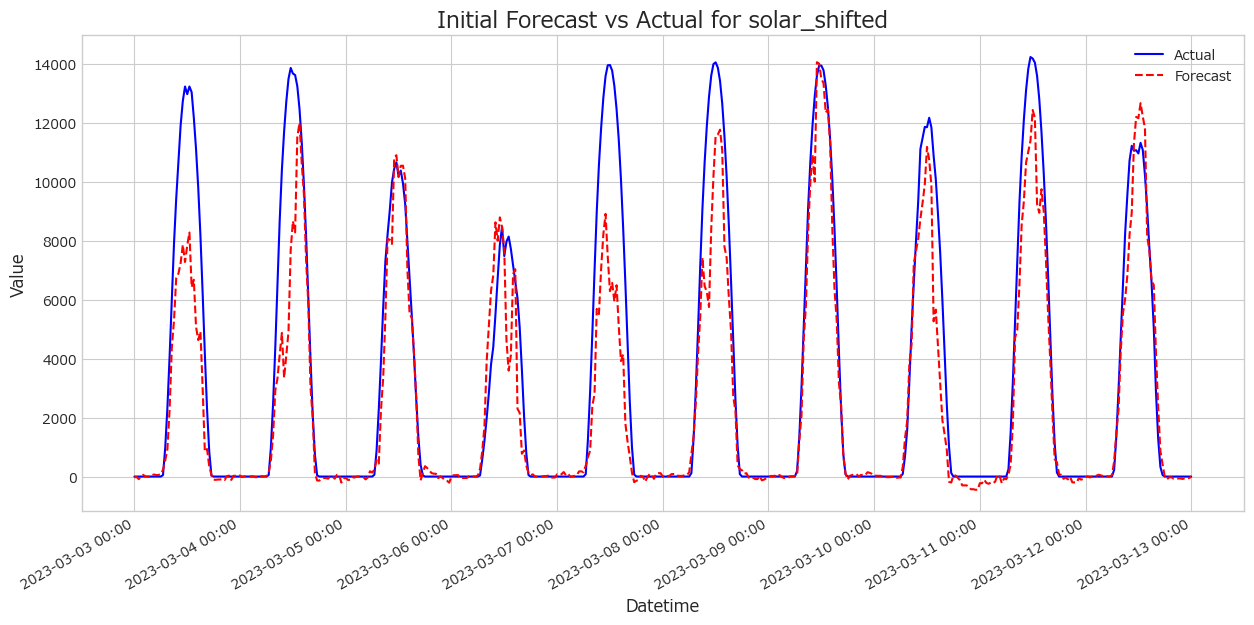

In [5]:
print("[Phase 1/3] Running initial forecast with default parameters...")
initial_results_solar, _, _ = sliding_window_forecast_with_features(
    data=df, y_col=target_col_solar, x_cols=feature_cols_solar,
    train_length=TRAIN_LENGTH, test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT, stride=STRIDE,
    model_func=lgb_forecast, model_params={'verbose': -1}
)
# Revert y_shifted
initial_results_solar = initial_results_solar.shift(48).dropna()

y_train_gen = df['solar_shifted'].iloc[:TRAIN_LENGTH]
initial_metrics_solar = evaluate_forecast(initial_results_solar['true'], initial_results_solar['pred'], y_train_gen.values, m=48)
print("Initial Forecast Metrics:")
print(pd.Series(initial_metrics_solar))
plot_forecast_vs_actual(initial_results_solar, f'Initial Forecast vs Actual for {target_col_solar}')


```
Initial Forecast Metrics:
MAE     1358.231313
RMSE    2728.585423
MASE       1.846009
```

**Discussion of Results**
Review the evaluation metrics of the baseline model and the graphs of prediction results.

- **Evaluation Metrics**: Initially, the MASE was below 1, which was an exceptionally good value compared to other methods. This prompted a check for logic errors and data leakage. I corrected a missing component responsible for training and prediction by shifting y or X. As a result, a MASE of 1.85 was achieved, which, even before tuning, yielded superior results compared to other methods.
- **Visualization**: Looking at the graphs, a tendency to be influenced by the previous day's weather still remains, but the zero output during nighttime is relatively well reproduced.

Relatively good results were obtained even with default settings, suggesting that LightGBM has good potential for solar power generation prediction tasks. Next, to further improve these results, hyperparameter optimization will be performed.


#### 7-2-2. Hyperparameter Optimization with Optuna
- Using Optuna, we explored the combination of hyperparameters that maximizes prediction accuracy (RMSE). The parameters targeted for exploration were the four main parameters that significantly influence model performance: the number of leaves `num_leaves`, the maximum tree depth `max_depth`, the learning rate `learning_rate`, and the minimum number of samples per leaf `min_child_samples`. Although the training period was 48 days, slightly shorter than the actual prediction, optimization was performed using a sliding window approach and early stopping.


In [6]:
print(f"[Phase 2/3] Running hyperparameter tuning with Optuna ({OPTUNA_TRIALS} trials)...")

# Tuning uses only the data from the initial TRAIN_LENGTH (60 days) and performs CV within it.
tuning_data_solar = df.iloc[:TRAIN_LENGTH].copy()

# Optuna's objective function
def objective_solar(trial: optuna.Trial) -> float:
    """Optuna's objective function (Sliding CV + Early Stopping)"""
    
    # Preparation for Early Stopping
    validation_ratio = 0.1 # Ratio of training data within CV to use for validation
    train_len_for_cv = 48 * 48  # Training period within CV (48 days)
    val_len = int(train_len_for_cv * validation_ratio)
    train_len = train_len_for_cv - val_len

    # Callable for dynamically creating evaluation sets
    def eval_set_provider(X_train, y_train):
        X_tr, X_val = X_train.iloc[:train_len], X_train.iloc[train_len:]
        y_tr, y_val = y_train.iloc[:train_len], y_train.iloc[train_len:]
        # eval_set is in the format [(X_val, y_val)]
        return ([(X_val, y_val)], X_tr, y_tr)

    # Callback creation
    early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)
    # Pruning callback
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")

    params = {
        'objective': 'regression_l1', # MAE
        'metric': 'rmse',
        'n_estimators': 1000, # Set generously and rely on Early Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        # Arguments for fit()
        "eval_set_provider": eval_set_provider,
        "callbacks": [early_stopping_callback, pruning_callback]
    }

    # Execute sliding window CV
    results_df, _, _ = sliding_window_forecast_with_features(
        data=tuning_data_solar,
        y_col=target_col_solar,
        x_cols=feature_cols_solar,
        train_length=train_len_for_cv, # 48 days
        test_length=48,                # 1 day
        slide_count=12,                # 12 slides (uses a total of 48+12 = 60 days of data)
        stride=48,                     # 1 day at a time
        model_func=lgb_forecast,       # Modified wrapper function
        model_params=params
    )
    
    rmse = np.sqrt(mean_squared_error(results_df['true'], results_df['pred']))
    return rmse

# Execute Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_solar = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

study_solar.optimize(objective_solar, n_trials=OPTUNA_TRIALS, show_progress_bar=True) 

best_params_solar = study_solar.best_params
print(f"Best parameters found for {target_col_solar}: {best_params_solar}")


[Phase 2/3] Running hyperparameter tuning with Optuna (40 trials)...


  0%|          | 0/40 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters found for solar_shifted: {'learning_rate': 0.168063935167146, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 99}


#### 7-2-3. Final Prediction and Evaluation with the Optimized Model
- Using the optimal hyperparameters obtained by Optuna, the sliding window prediction is performed again to evaluate the final model's performance.


[Phase 3/3] Running final forecast with best parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

{'learning_rate': 0.168063935167146, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 99}
Final Forecast Metrics (with tuned parameters):
MAE     1444.925209
RMSE    2543.057874
MASE       1.963837
dtype: float64


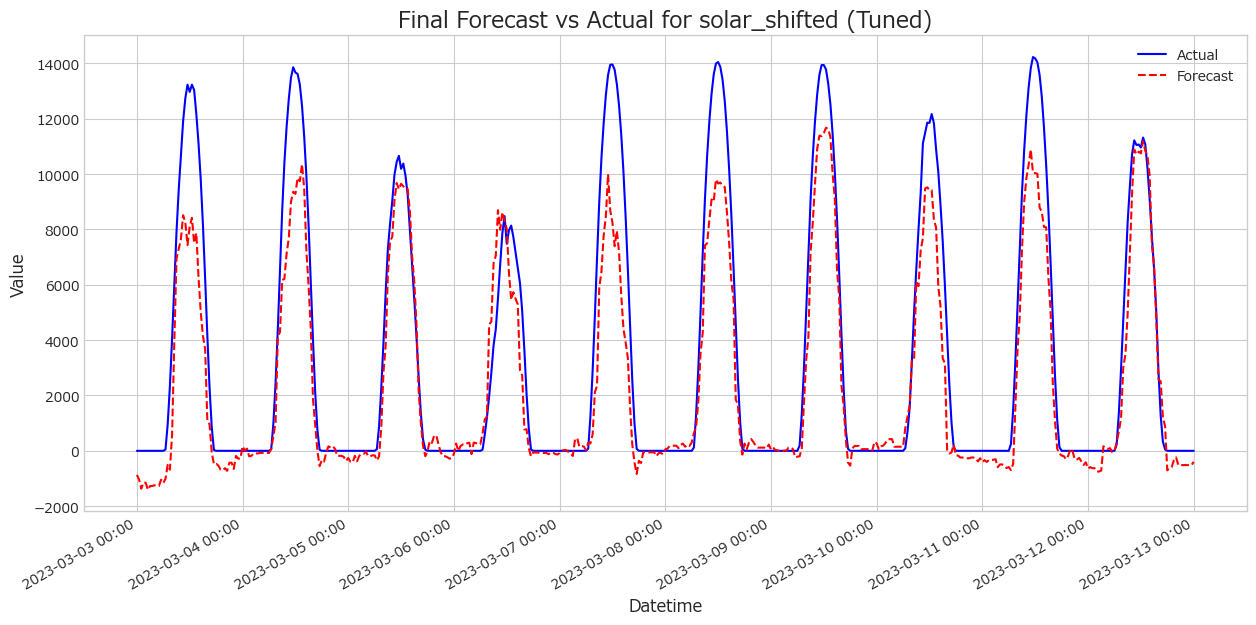

In [7]:
print("[Phase 3/3] Running final forecast with best parameters...")
final_results_solar, _, _ = sliding_window_forecast_with_features(
    data=df, y_col=target_col_solar, x_cols=feature_cols_solar,
    train_length=TRAIN_LENGTH, test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT, stride=STRIDE,
    model_func=lgb_forecast, model_params={**best_params_solar, 'verbose': -1}
)
print(best_params_solar)
# Restore y-axis dates
final_results_solar = final_results_solar.shift(48).dropna()

y_train_gen = df['solar_shifted'].iloc[:TRAIN_LENGTH]
final_metrics_solar = evaluate_forecast(final_results_solar['true'], final_results_solar['pred'], y_train_gen.values, m=48)
print("Final Forecast Metrics (with tuned parameters):")
print(pd.Series(final_metrics_solar))
plot_forecast_vs_actual(final_results_solar, f'Final Forecast vs Actual for {target_col_solar} (Tuned)')


```
{'learning_rate': 0.168063935167146, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 99}
Final Forecast Metrics (with tuned parameters):
MAE     1444.925209
RMSE    2543.057874
MASE       1.963837
dtype: float64
```


**Discussion of Results**
- **Accuracy Improvement**: Compared to baseline predictions, RMSE improved, while MAE and MASE worsened. Only RMSE decreased, suggesting that although large errors were reduced, the generalization performance is presumed to have deteriorated.
- **Model Characteristics**: Upon examining the optimized parameters, `max_depth` is relatively small, while `num_leaves` and `min_child_samples` are large. This suggests that instead of creating excessively deep trees, a slightly overfitted model was constructed by having numerous leaves at a moderate depth.

These results suggest the necessity for further exploration in hyperparameter optimization, such as additional strategies or expanding the range of parameters.


### 7-3. Prediction of Electricity Demand (e_demand_mw: demand_shifted)


In [8]:
# Set the variable to be predicted
target_col_demand = 'demand_shifted'
feature_cols_demand = TARGETS[target_col_demand]
print(f" Starting Forecast for: {target_col_demand}")


 Starting Forecast for: demand_shifted


#### 7-3-1. Baseline Prediction


[Phase 1/3] Running initial forecast with default parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

Initial Forecast Metrics:
MAE     2657.463819
RMSE    3356.735753
MASE       0.841521
dtype: float64


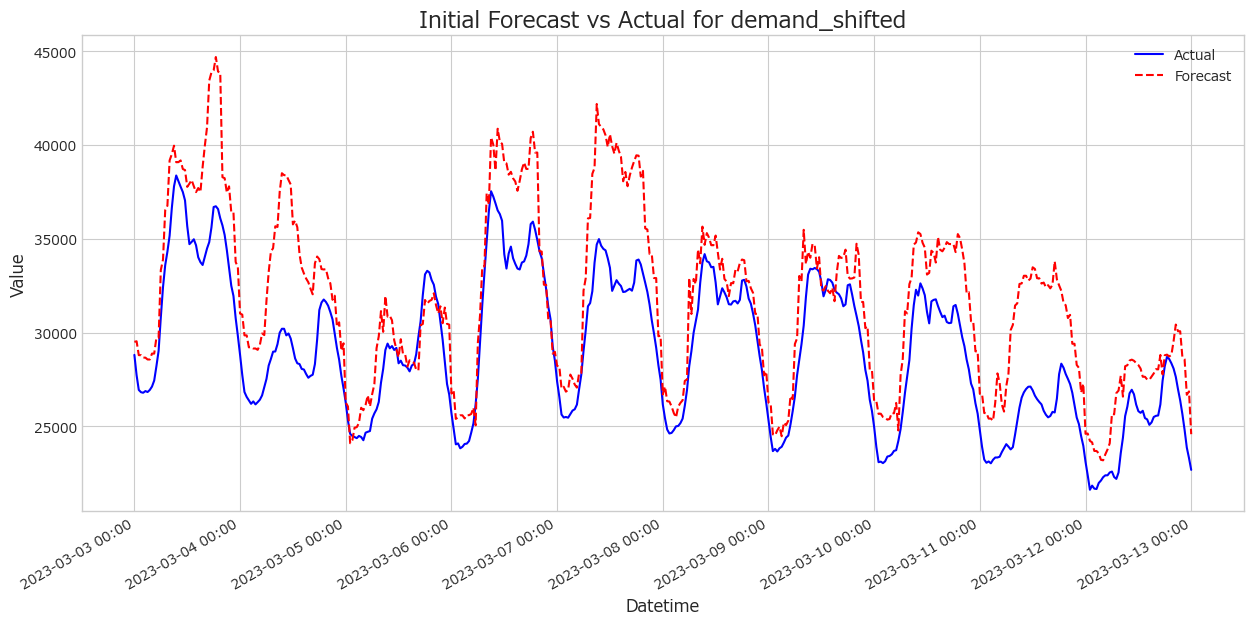

In [9]:
print("[Phase 1/3] Running initial forecast with default parameters...")
initial_results_demand, _, _ = sliding_window_forecast_with_features(
    data=df, y_col=target_col_demand, x_cols=feature_cols_demand,
    train_length=TRAIN_LENGTH, test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT, stride=STRIDE,
    model_func=lgb_forecast, model_params={'verbose': -1}
)
# Restore y-axis dates
initial_results_demand = initial_results_demand.shift(48).dropna()

y_train_gen = df['demand_shifted'].iloc[:TRAIN_LENGTH]
initial_metrics_demand = evaluate_forecast(initial_results_demand['true'], initial_results_demand['pred'], y_train_gen.values, m=336)
print("Initial Forecast Metrics:")
print(pd.Series(initial_metrics_demand))
plot_forecast_vs_actual(initial_results_demand, f'Initial Forecast vs Actual for {target_col_demand}')


```
Initial Forecast Metrics:
MAE     2657.463819
RMSE    3356.735753
MASE       0.841521
```

#### 7-3-2. Hyperparameter Optimization using Optuna
- Similarly, hyperparameter optimization for the electricity demand prediction model will be performed using Optuna.


In [10]:
print(f"[Phase 2/3] Running hyperparameter tuning with Optuna ({OPTUNA_TRIALS} trials)...")

# Tuning uses only the data from the initial TRAIN_LENGTH (60 days), and performs CV within it.
tuning_data_demand = df.iloc[:TRAIN_LENGTH].copy()

# Optuna's objective function
def objective_demand(trial: optuna.Trial) -> float:
    """Optuna's objective function (Sliding CV + Early Stopping)"""
    
    # Preparation for Early Stopping
    validation_ratio = 0.1 # Ratio of training data within CV to be used for validation
    train_len_for_cv = 48 * 48  # Training period within CV (48 days)
    val_len = int(train_len_for_cv * validation_ratio)
    train_len = train_len_for_cv - val_len

    # Callable for dynamically creating evaluation sets
    def eval_set_provider(X_train, y_train):
        X_tr, X_val = X_train.iloc[:train_len], X_train.iloc[train_len:]
        y_tr, y_val = y_train.iloc[:train_len], y_train.iloc[train_len:]
        # eval_set is in the format [(X_val, y_val)]
        return ([(X_val, y_val)], X_tr, y_tr)

    # Create callbacks
    early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)
    # Pruning callback
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")

    params = {
        'objective': 'regression_l1', # MAE
        'metric': 'rmse',
        'n_estimators': 1000, # Set a generous number, and leave it to Early Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        # Arguments for fit()
        "eval_set_provider": eval_set_provider,
        "callbacks": [early_stopping_callback, pruning_callback]
    }

    # Execute Sliding Window CV
    results_df, _, _ = sliding_window_forecast_with_features(
        data=tuning_data_demand,
        y_col=target_col_demand,
        x_cols=feature_cols_demand,
        train_length=train_len_for_cv, # 48 days
        test_length=48,                # 1 day
        slide_count=12,                # 12 slides (uses a total of 48+12 = 60 days of data)
        stride=48,                     # 1 day at a time
        model_func=lgb_forecast,       # Modified wrapper function
        model_params=params
    )
    
    rmse = np.sqrt(mean_squared_error(results_df['true'], results_df['pred']))
    return rmse

# Execute Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_demand = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

study_demand.optimize(objective_demand, n_trials=OPTUNA_TRIALS, show_progress_bar=True) 

best_params_demand = study_demand.best_params
print(f"Best parameters found for {target_col_demand}: {best_params_demand}")


[Phase 2/3] Running hyperparameter tuning with Optuna (40 trials)...


  0%|          | 0/40 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters found for demand_shifted: {'learning_rate': 0.2297549470167101, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 72}


#### 7-3-3. Final Prediction and Evaluation Using the Optimized Model
- Perform final predictions using the optimized hyperparameters and evaluate performance.


[Phase 3/3] Running final forecast with best parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

{'learning_rate': 0.2297549470167101, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 72}
Final Forecast Metrics (with tuned parameters):
MAE     2718.377158
RMSE    3475.883527
MASE       0.860810
dtype: float64


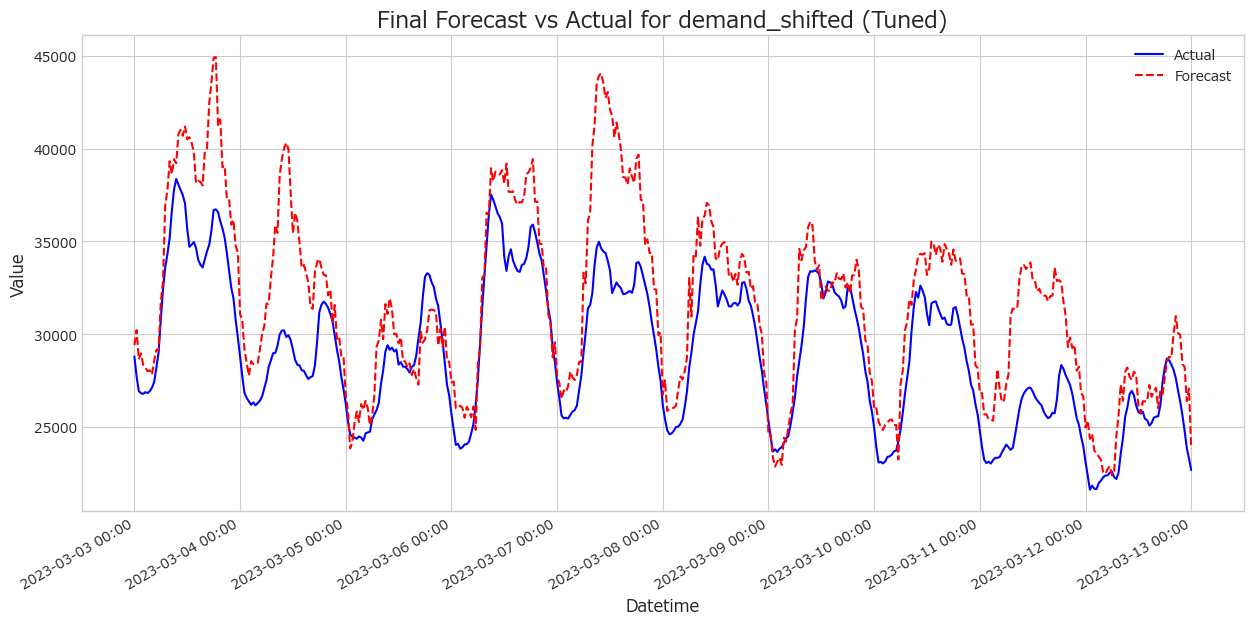

In [11]:
print("[Phase 3/3] Running final forecast with best parameters...")
final_results_demand, _, _ = sliding_window_forecast_with_features(
    data=df, y_col=target_col_demand, x_cols=feature_cols_demand,
    train_length=TRAIN_LENGTH, test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT, stride=STRIDE,
    model_func=lgb_forecast, model_params={**best_params_demand, 'verbose': -1},
)
print(best_params_demand)
# Restore y-axis dates
final_results_demand = final_results_demand.shift(48).dropna()

y_train_con = df['demand_shifted'].iloc[:TRAIN_LENGTH]

final_metrics_demand = evaluate_forecast(final_results_demand['true'], final_results_demand['pred'], y_train_con.values, m=336)
print("Final Forecast Metrics (with tuned parameters):")
print(pd.Series(final_metrics_demand))
plot_forecast_vs_actual(final_results_demand, f'Final Forecast vs Actual for {target_col_demand} (Tuned)')


```
{'learning_rate': 0.2297549470167101, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 72}
Final Forecast Metrics (with tuned parameters):
MAE     2718.377158
RMSE    3475.883527
MASE       0.860810
```


**Discussion of Results**
- **Performance Improvement**: Compared to baseline predictions, no improvement was observed in the evaluation metrics. Although the graph appeared to capture subtle changes well, I had the impression of a vertical divergence in absolute positions.

- **Comparison**: Compared to classical models, the results were not favorable either before or after tuning. Furthermore, given the unusual relationship between the increase in LASSO regularization coefficients and the increase in model error during feature selection, it is considered necessary to explore methods for improving both feature selection and tuning methodologies.


In [12]:
# Combine evaluation results table
comparison_df = pd.DataFrame({
    'Solar_Initial': initial_metrics_solar,
    'Solar_Tuned': final_metrics_solar,
    'Demand_Initial': initial_metrics_demand,
    'Demand_Tuned': final_metrics_demand
})
print(comparison_df)


      Solar_Initial  Solar_Tuned  Demand_Initial  Demand_Tuned
MAE     1358.231313  1444.925209     2657.463819   2718.377158
RMSE    2728.585423  2543.057874     3356.735753   3475.883527
MASE       1.846009     1.963837        0.841521      0.860810


In [13]:
# Save results
# Assuming pred_df has 'true', 'pred' columns and a datetime index

# Power generation
initial_results_solar.to_pickle('../results/preds/solar_lightGBM.pkl')
print("Saved: ")

# Demand
initial_results_demand.to_pickle('../results/preds/demand_lightGBM.pkl')
print("Saved: ")


Saved: 
Saved: 


### 7-4. Conclusion and Discussion


In this analysis, a time series forecasting model for solar power generation and electricity demand was constructed using LightGBM.

#### Summary
- **Suitability of LightGBM**: For power generation, LightGBM showed high prediction accuracy even with default parameters. In particular, it demonstrated excellent capability in capturing nonlinear relationships, such as accurately predicting zero generation at night for solar power and capturing complex periodicities in electricity demand.
- **Effectiveness of Hyperparameter Optimization**: Optimization using Optuna resulted in only limited accuracy improvement from the baseline for both models. This suggests the need to explore more appropriate tuning methods and to expand or carefully select the parameters to be tuned.
- **Practicality**: LightGBM combines high learning speed with a certain level of prediction accuracy. Provided that features are prepared, it can be a powerful and practical first choice for time series forecasting tasks.

#### Insights from Comparison with Other Models
Compared to previous analyses (`Holt-Winters`, `SARIMAX`, `Prophet`), the following insights were gained.

- **Vs. SARIMA**: SARIMAX and Prophet models had the challenge of somewhat higher computational load, especially for data with long periodicities such as weekly cycles (m=336). In contrast, LightGBM directly handles temporal information (day of the week, time of day, etc.) as features, allowing for fast learning independent of the cycle length. This offers a significant advantage in terms of computational efficiency, though SARIMAX seemed to capture periodicity well in terms of accuracy.
- **Vs. Holt-Winters**: For electricity demand forecasting, the Holt-Winters model showed good results, whereas LightGBM, despite incorporating external features like temperature and humidity, did not achieve comparable accuracy. For solar power generation forecasting, LightGBM, utilizing weather-related features, demonstrated relatively superior performance.

#### Future Prospects
- **Feature Deepening**: By explicitly adding lag features and moving average features, the model could more directly learn temporal autocorrelation, potentially leading to further accuracy improvements. For electricity demand, using `feature_importance` from models like Random Forest or LightGBM to make more appropriate feature selections is also a potential improvement.
- **Residual Analysis**: Statistically testing (e.g., Ljung-Box test) whether autocorrelation remains in the prediction errors (residuals) or if they exhibit normality can help evaluate if the model is failing to capture certain information, leading to potential improvements.
- **Improvements in Tuning Methodology**: This time, parameter tuning with Optuna did not improve accuracy. The challenge lies in exploring and adopting improved methods, such as employing standard cross-validation techniques, modifying or expanding the target parameters, and devising effective early stopping strategies.

Considering practical implementation for solar power generation, LightGBM is likely to be a strong candidate due to its advantages in:
* Processing speed
* Ease of human understanding and interpretability of adopted variables
* Maintainability of the overall program
